## Matrix Multiplication

In [1]:
import torch
import triton
from functions.MatrixMultiple import mm

DEVICE = triton.runtime.driver.active.get_active_torch_device()
import os
os.TRITON_PRINT_AUTOTUNING = 1


### Benchmark

In [2]:
benchmark_config = triton.testing.Benchmark(
    x_names=["M", "N", "K"],
    x_vals=[512 * i for i in range(4, 30)],
    line_arg='provider',
    line_vals=['mm', 'grouped_mm','naive_mm', 'torch'],
    line_names=['Official', 'Grouped', 'Naive', 'Torch'],
    styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('orange', '-')],
    ylabel='TFLOPs',
    plot_name='mm performance',
    args={},    
)

In [3]:
@triton.testing.perf_report(benchmark_config)
def benchmark(M,N,K, provider): # name of args should be aligned with
                                     # 'x_names' and 'line_arg' in 'benchmark_config' function
    x = torch.randn(M, K, device=DEVICE, dtype=torch.float16)
    w = torch.randn(K, N, device=DEVICE, dtype=torch.float16)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x@w, quantiles=quantiles)
    if provider == 'naive_mm':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mm(x, w, kernel_name='naive'), quantiles=quantiles)
    if provider == 'grouped_mm':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mm(x, w, kernel_name='group'), quantiles=quantiles)
    if provider == 'mm':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mm(x, w, kernel_name='official'), quantiles=quantiles)
        
    tflops = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return tflops(ms), tflops(max_ms), tflops(min_ms)

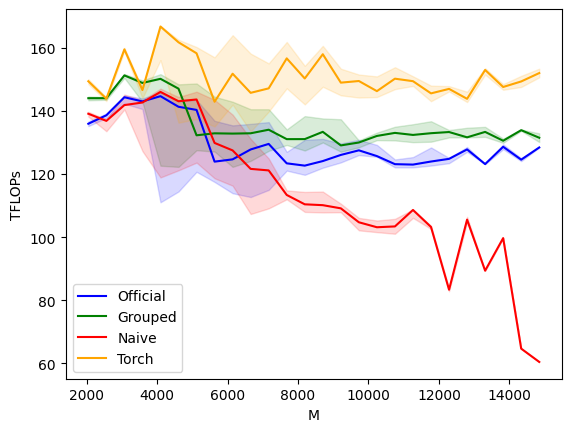

mm performance:
          M        N        K    Official     Grouped       Naive       Torch
0    2048.0   2048.0   2048.0  135.985547  144.087739  139.157830  149.462944
1    2560.0   2560.0   2560.0  138.663848  144.094540  136.889815  143.936311
2    3072.0   3072.0   3072.0  144.389142  151.322805  141.901431  159.593022
3    3584.0   3584.0   3584.0  143.063475  148.928186  142.722846  146.673426
4    4096.0   4096.0   4096.0  144.733521  150.236719  146.082356  166.833717
5    4608.0   4608.0   4608.0  141.367960  147.113682  143.124841  161.827389
6    5120.0   5120.0   5120.0  140.373972  132.316596  143.678685  158.341345
7    5632.0   5632.0   5632.0  123.960400  132.944816  129.892530  142.962613
8    6144.0   6144.0   6144.0  124.681874  132.857176  127.524463  151.860228
9    6656.0   6656.0   6656.0  127.820307  132.955592  121.659104  145.790744
10   7168.0   7168.0   7168.0  129.581143  134.084818  121.172121  147.208563
11   7680.0   7680.0   7680.0  123.418884  131.0

In [4]:
benchmark.run(print_data=True, show_plots=True)

In [5]:
@triton.testing.perf_report(benchmark_config)
def benchmark_T(M,N,K, provider): # name of args should be aligned with
                                     # 'x_names' and 'line_arg' in 'benchmark_config' function
    x = torch.randn(M, K, device=DEVICE, dtype=torch.float16)
    w = torch.randn(K, N, device=DEVICE, dtype=torch.float16)
    w = w.T
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x@w, quantiles=quantiles)
    if provider == 'naive_mm':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mm(x, w, kernel_name='naive'), quantiles=quantiles)
    if provider == 'grouped_mm':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mm(x, w, kernel_name='group'), quantiles=quantiles)
    if provider == 'mm':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mm(x, w, kernel_name='official'), quantiles=quantiles)
        
    tflops = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return tflops(ms), tflops(max_ms), tflops(min_ms)

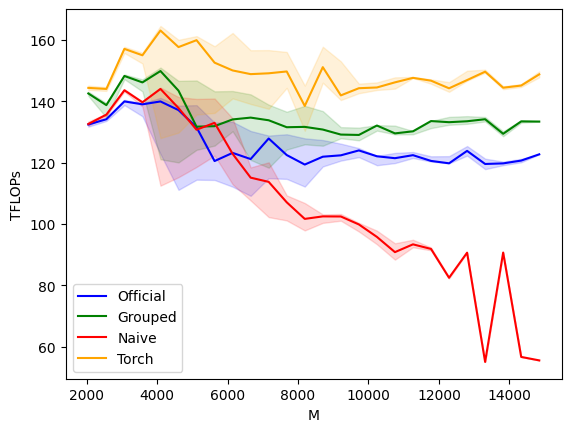

mm performance:
          M        N        K    Official     Grouped       Naive       Torch
0    2048.0   2048.0   2048.0  132.446259  142.576260  132.626210  144.397775
1    2560.0   2560.0   2560.0  134.166212  138.773958  135.667746  144.054957
2    3072.0   3072.0   3072.0  139.982954  148.288680  143.622329  157.122727
3    3584.0   3584.0   3584.0  139.033217  146.185315  139.698133  155.034895
4    4096.0   4096.0   4096.0  139.974166  149.893289  144.053911  163.117575
5    4608.0   4608.0   4608.0  137.154217  143.494266  137.818788  157.708257
6    5120.0   5120.0   5120.0  131.542672  131.743060  130.747174  159.959729
7    5632.0   5632.0   5632.0  120.533264  131.910533  133.001824  152.626471
8    6144.0   6144.0   6144.0  123.196231  134.110939  122.886566  150.088158
9    6656.0   6656.0   6656.0  121.179933  134.701840  115.114129  148.884739
10   7168.0   7168.0   7168.0  127.888197  133.834559  113.735691  149.157861
11   7680.0   7680.0   7680.0  122.487125  131.5

In [6]:
benchmark_T.run(print_data=True, show_plots=True)

### Profile

In [7]:
M, N, K = 1024, 1024, 1024
x = torch.rand(M, K, device=DEVICE, dtype=torch.float32)
w = torch.rand(N, K, device=DEVICE, dtype=torch.float32)

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU,
                torch.profiler.ProfilerActivity.CUDA],
    record_shapes=True,
    with_stack=True,
    profile_memory=True,
) as prof:
    # run the kernel you want to profile
    mm(x, w, kernel_name='naive')
print('profile of mmT:')
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))


profile of mmT:
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    naive_mm_kernel_use_block_ptr         0.00%       0.000us         0.00%       0.000us       0.000us      73.537us       100.00%      73.537us      73.537us           0 B           0 B           0 B           0 B             1  
                      aten::empty         2.29%      5

In [8]:
M, N, K = 1024, 1024, 1024
x = torch.rand(M, K, device=DEVICE, dtype=torch.float32)
w = torch.rand(K, N, device=DEVICE, dtype=torch.float32)

with torch.profiler.profile(
    # activities=[torch.profiler.ProfilerActivity.CPU,
    # #             torch.profiler.ProfilerActivity.CUDA],
    # record_shapes=True,
    # with_stack=True,
    # profile_memory=True,
) as prof:
    # run the kernel you want to profile
    mm(x, w, kernel_name='group')
print('profile of mm:')
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

profile of mm:
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
     grouped_mm_2D_kernel         0.00%       0.000us         0.00%       0.000us       0.000us      65.601us       100.00%      65.601us      65.601us             1  
              aten::empty         1.02%      24.498us        95.92%       2.300ms       2.300ms       0.000us         0.00%       0.000us       0.000us             1  
             Unrecognized        94.89%       2.275ms        94.89%       2.275ms       2.275ms       0.000us         0.00%       0.000us       